<a href="https://colab.research.google.com/github/wenjunsun/personal-machine-learning-projects/blob/master/unsupervised-learning/NLP_about_amazon_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook I will explore Amazon's reviews data, and do some clustering analysis - what kind of comments tend to lump together? Maybe I can do some elementary sentiment analysis about which comments are positive and which comments are negative as well. Pretty exciting! Let's get started! This is my first time doing an NLP project, I used to always work with extracting insights from numbers, so let's see how far I can get with doing the same thing twith words and sentences.

This whole notebook is done in Google Colab, which provides 12 GB of RAM and 100 GB hard drive. I don't see a better free platform than Google Colab. But of course you can do all of the following on your own local machine. 

# Step 1. download and load data.

## 1.1 find the data, download it onto Colab drive, explore in bash

First we need to download review data from Aamzon. There are many choices about how to get that data of course. [I choose the data source from this website](https://s3.amazonaws.com/amazon-reviews-pds/readme.html). Amazon releases its own data on this web, which is a better source than other third-party dataset hosts. 

If you have trouble finding where the data is, [go to this index file](https://s3.amazonaws.com/amazon-reviews-pds/tsv/index.txt), in it you will see the download links for all kinds of review datasets, in URL links with .tsv.gz at the end. There are many kinds of reviews as we can see. There are reviews about video games, watches, and books. I like books, so I am going to use that dataset, but of course you can use any dataset you want.

Anyway, assuming you are on colab, you can copy the link to your favorite dataset, and do the following command in bash. Then you will have the data sitting in your colab drive.

In [ ]:
%%bash
wget https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Books_v1_02.tsv.gz # replace by your own data link here.

In [6]:
# since the data is in .gz formate (compressed like .zip file),
# we need to unzip it. This is how you unzip a file in bash:
%%bash
gunzip amazon_reviews_us_Books_v1_02.tsv.gz 

In [ ]:
ls

amazon_reviews_us_Books_v1_02.tsv  sample_data/


Now we can see our data in .tsv file. (3 GB). tsv means separated by tabs. (csv is separated by comma)

Before we even load this file into a pandas dataframe, let's just do a little bit of exploration in bash. For example we can find out how many lines this file has, and we can see its first 5 lines, etc.

In [ ]:
# count how many lines this file has.
%%bash
wc -l amazon_reviews_us_Books_v1_02.tsv

3105521 amazon_reviews_us_Books_v1_02.tsv


We can see that we have about 3 million lines of data.

In [ ]:
# print out first 5 lines.
%%bash
head -5 amazon_reviews_us_Books_v1_02.tsv

marketplace	customer_id	review_id	product_id	product_parent	product_title	product_category	star_rating	helpful_votes	total_votes	vine	verified_purchase	review_headline	review_body	review_date
US	12076615	RQ58W7SMO911M	0385730586	122662979	Sisterhood of the Traveling Pants (Book 1)	Books	4	2	3	N	N	this book was a great learning novel!	this boook was a great one that you could learn from. it not only teaches the imponrtance of family and their values but it also deals with basic issues that teens and some kids even deal with.  this book is about 4 best friends who are for the first time in their lives spending their summer apart. one day they are all in one of the girls rooms and finds a pair of pants that were tucked away in her closet.  once all four  of them try them on they realize that there is really something special about these pants.  seeming as how all 4 girls are differnt shapes and sizes and somehow the pants fit all of them,  they realize that these pants were the start of s

we can see that first row is the column names of the data, we have the name of the product, and the rating, and of course the reviews and the date of the review. Looks super interesting!!!! Now let's load this data into python dataframe.

## 1.2 load data into python dataframe

In [7]:
# load necessary packages.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
ls

amazon_reviews_us_Books_v1_02.tsv  sample_data/


In [ ]:
book_review_data = pd.read_csv("amazon_reviews_us_Books_v1_02.tsv", sep = "\t")

ParserError: ignored

Okay we see that we have some lines that correspond to "bad data", some lines have 22 fields while we are only expecting 15. For now let's just not load those bad lines into our dataframe. There is a way to do this with *read_csv* function with a extra parameter.

In [ ]:
book_review_data = pd.read_csv("amazon_reviews_us_Books_v1_02.tsv", sep = "\t", error_bad_lines = False) 
# error_bad_lines = False just tells parser to ignore bad lines in .tsv file.
# only read in the lines that make sense.

b'Skipping line 1680001: expected 15 fields, saw 22\n'


# Step 2: explore data.

## 2.1 Play with our data!!

In [ ]:
# look at our data.
book_review_data.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12076615,RQ58W7SMO911M,0385730586,122662979,Sisterhood of the Traveling Pants (Book 1),Books,4.0,2.0,3.0,N,N,this book was a great learning novel!,this boook was a great one that you could lear...,2005-10-14
1,US,12703090,RF6IUKMGL8SF,0811828964,56191234,The Bad Girl's Guide to Getting What You Want,Books,3.0,5.0,5.0,N,N,Fun Fluff,If you are looking for something to stimulate ...,2005-10-14
2,US,12257412,R1DOSHH6AI622S,1844161560,253182049,"Eisenhorn (A Warhammer 40,000 Omnibus)",Books,4.0,1.0,22.0,N,N,this isn't a review,never read it-a young relative idicated he lik...,2005-10-14
3,US,50732546,RATOTLA3OF70O,0373836635,348672532,Colby Conspiracy (Colby Agency),Books,5.0,2.0,2.0,N,N,fine author on her A-game,Though she is honored to be Chicago Woman of t...,2005-10-14
4,US,51964897,R1TNWRKIVHVYOV,0262181533,598678717,The Psychology of Proof: Deductive Reasoning i...,Books,4.0,0.0,2.0,N,N,Execellent cursor examination,Review based on a cursory examination by Unive...,2005-10-14


In [ ]:
# print out the first review we have.
# this looks like a positive review.
book_review_data.loc[0,'review_body']

'this boook was a great one that you could learn from. it not only teaches the imponrtance of family and their values but it also deals with basic issues that teens and some kids even deal with.  this book is about 4 best friends who are for the first time in their lives spending their summer apart. one day they are all in one of the girls rooms and finds a pair of pants that were tucked away in her closet.  once all four  of them try them on they realize that there is really something special about these pants.  seeming as how all 4 girls are differnt shapes and sizes and somehow the pants fit all of them,  they realize that these pants were the start of something special.  immediatley following they decided to make up certian rules abut the pants such as you must write the best thing u did while wearing the pants over your summer on the right leg and also some silly things such as to \\\\"never pick yuor nose while wearing the pants.\\\\"  this book follows the girls throuh their sum

In [ ]:
# as we can see, we have 3 million data points about book reviews.
# don't think 3 million is "big data", but every row contains
# rich information about reviews, which is not just some numbers.
book_review_data.shape

(3105370, 15)

In [ ]:
# look at data types. - in some datasets ints looks like ints
# but are actually strings.
book_review_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3105370 entries, 0 to 3105369
Data columns (total 15 columns):
 #   Column             Dtype  
---  ------             -----  
 0   marketplace        object 
 1   customer_id        int64  
 2   review_id          object 
 3   product_id         object 
 4   product_parent     int64  
 5   product_title      object 
 6   product_category   object 
 7   star_rating        float64
 8   helpful_votes      float64
 9   total_votes        float64
 10  vine               object 
 11  verified_purchase  object 
 12  review_headline    object 
 13  review_body        object 
 14  review_date        object 
dtypes: float64(3), int64(2), object(10)
memory usage: 355.4+ MB


In [ ]:
# there are some null rows, not that much
# compared to our 3 million data points
book_review_data.isnull().sum()

marketplace            0
customer_id            0
review_id              0
product_id             0
product_parent         0
product_title          0
product_category       0
star_rating            4
helpful_votes          4
total_votes            4
vine                   4
verified_purchase      4
review_headline       42
review_body            4
review_date          133
dtype: int64

In [ ]:
book_review_data.head()['review_date']

0    2005-10-14
1    2005-10-14
2    2005-10-14
3    2005-10-14
4    2005-10-14
Name: review_date, dtype: object

In [ ]:
book_review_data.tail()['review_date']

3105365    1995-07-19
3105366    1995-07-18
3105367    1995-07-07
3105368    1995-06-24
3105369    1995-06-24
Name: review_date, dtype: object

From above we can see this dataset's reviews are from year 1995 to 2005, pretty ancient lol... (Right now it is 2020.) Will be interesting to find out 20 years ago people's taste in books!


In [ ]:
book_review_data

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12076615,RQ58W7SMO911M,0385730586,122662979,Sisterhood of the Traveling Pants (Book 1),Books,4.0,2.0,3.0,N,N,this book was a great learning novel!,this boook was a great one that you could lear...,2005-10-14
1,US,12703090,RF6IUKMGL8SF,0811828964,56191234,The Bad Girl's Guide to Getting What You Want,Books,3.0,5.0,5.0,N,N,Fun Fluff,If you are looking for something to stimulate ...,2005-10-14
2,US,12257412,R1DOSHH6AI622S,1844161560,253182049,"Eisenhorn (A Warhammer 40,000 Omnibus)",Books,4.0,1.0,22.0,N,N,this isn't a review,never read it-a young relative idicated he lik...,2005-10-14
3,US,50732546,RATOTLA3OF70O,0373836635,348672532,Colby Conspiracy (Colby Agency),Books,5.0,2.0,2.0,N,N,fine author on her A-game,Though she is honored to be Chicago Woman of t...,2005-10-14
4,US,51964897,R1TNWRKIVHVYOV,0262181533,598678717,The Psychology of Proof: Deductive Reasoning i...,Books,4.0,0.0,2.0,N,N,Execellent cursor examination,Review based on a cursory examination by Unive...,2005-10-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3105365,US,53096582,R1U2RAML67OKWM,0471114251,574261099,Bitter Winds: A Memoir of My Years in China's ...,Books,4.0,9.0,9.0,N,N,Harry Wu could have taught Kafka a thing or two.,&quot;Bitter Winds&quot; is at once fascinatin...,1995-07-19
3105366,US,53011769,R33HOJ2OWJIDQI,089145537X,836948045,The Collector's Guide to Harker Pottery U.S.A....,Books,5.0,27.0,27.0,N,N,The definitive volume on Harker Pottery,"OK, I'm biased. My mother wrote this one. Many...",1995-07-18
3105367,US,53096573,RPLV77JZXG575,047194128X,377091465,Object-Oriented Type Systems,Books,4.0,4.0,4.0,N,N,"Good techniques, well written.",The best (and possibly only) book I've seen on...,1995-07-07
3105368,US,53096571,RHL4UW17ZK72A,0521314925,980601331,Invention and Evolution:Design in Nature and E...,Books,5.0,9.0,9.0,N,N,BUY THIS BOOK!,This is a beautiful book. French talks about ...,1995-06-24


In [ ]:
# look at bad reviews for the book "Sisterhood of the Traveling Pants (Book 1)"
book_review_data[(book_review_data['product_title'] == 'Sisterhood of the Traveling Pants (Book 1)')& (book_review_data['star_rating'] < 3)]

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
132278,US,12799825,RLMD20PYH5VJL,0385730586,122662979,Sisterhood of the Traveling Pants (Book 1),Books,1.0,25.0,35.0,N,N,The Fall of the Sisterhood,I recently read The Sisterhood of the Travelin...,2005-08-03
161578,US,17580189,RCMW8NARCCMBL,0385730586,122662979,Sisterhood of the Traveling Pants (Book 1),Books,2.0,10.0,14.0,N,N,Too mature for young girls,I have to say that I am a little amazed at the...,2005-07-18
210661,US,24822026,RPGJKHGFQKXX9,0385730586,122662979,Sisterhood of the Traveling Pants (Book 1),Books,2.0,4.0,14.0,N,N,Do not read this!,I spent more than 7 dollors to buy this book a...,2005-06-09
278735,US,36610202,R22G6JK4SOEKY4,0385730586,122662979,Sisterhood of the Traveling Pants (Book 1),Books,1.0,26.0,38.0,N,N,Clichéd,"I'm a fifteen year old reader, and I typically...",2005-04-13
293886,US,23349377,RSQWUFUGP3VMU,0385730586,122662979,Sisterhood of the Traveling Pants (Book 1),Books,1.0,14.0,26.0,N,N,What's all the fuss?,I just don't get why this book is so popular. ...,2005-04-01
369134,US,14702007,R104D8BEQTESWJ,0385730586,122662979,Sisterhood of the Traveling Pants (Book 1),Books,1.0,6.0,27.0,N,N,The Sisterhood of the Traveling Pants,This book is not worth your time. It took me m...,2005-01-29
426232,US,35949446,R2UXGS8KLE2YKQ,0385730586,122662979,Sisterhood of the Traveling Pants (Book 1),Books,2.0,41.0,50.0,N,Y,Not appropriate for young girls- or older ones,I bought this book for my 12 year old niece af...,2004-12-12
630493,US,17899762,RHKL3VT2ZTYXG,0385730586,122662979,Sisterhood of the Traveling Pants (Book 1),Books,2.0,11.0,15.0,N,N,Disappointed - overrated and overhyped novel!,"I incessantly heard about how \\""great\\"" and ...",2004-06-14
709347,US,19451524,R1OXNMG4I56UBB,0385730586,122662979,Sisterhood of the Traveling Pants (Book 1),Books,1.0,5.0,14.0,N,N,Sisterhood Of the traveling Jeans,"Too be honest, this is only my opinion! This w...",2004-04-12
710655,US,19440744,R31JKWJRJGFYE,0385730586,122662979,Sisterhood of the Traveling Pants (Book 1),Books,1.0,8.0,17.0,N,N,The Sisterhood of Utter Crap,This is by far one the worst books I've ever r...,2004-04-12


In [ ]:
# look at the most helpful reviews rated by others about this book
most_helpful_review = book_review_data[(book_review_data['product_title'] == 'Sisterhood of the Traveling Pants (Book 1)') \
                                       & (book_review_data['helpful_votes'] > 100)]

In [ ]:
most_helpful_review['review_headline'].array[0]

'The Sisterhood of the Travelling Pants'

In [ ]:
most_helpful_review['review_body'].array[0]

'While overall, I thought this book was fine and possibly engaging for young women, I strongly think the 12 year old age guideline is too young, both for some of the contents of the plot and for the deeper and more meaningful aspects of what a girl could discover from the book.  In other words, I thought the chararacters were interesting to an older teen aged girl, but 12 year olds are not teenagers.  In fact, these characters are 15 and almost 16, all about to be juniors in high school.  And those ages, I think, as a mother, are the appropriate ages for a girl to be reading this book. Not only is there mature sexual content and encounter (albeit, which one of the characters cannot handle), the characters themselves, and their metamorphises, what they go through that summer, what they learn about themselves, will be much more understandable and appropriate to a 14 or 15 or 16 year old, then  to an impressionable 12 or 13 year old.  I would liken it to reading Jane Eyre, or Little Women

We can see that this reviewer said that the book is too mature for young girlds. This is interesting. Although I never read the book, this is a great insight to have as Amazon, or as the book writer. Amazon should suggest this book for >= 16 olds, and not 12 year olds.

# Step 3: define our problem

Obviously there are so many paths we can explore with this dataset! For example:

1. what books are gaining the most positive reviews? What kind of books are those (relevant for book writers and Amazon to think about what they want to sell more in the future. For example if we found out that now people are really into fantasy/romance, this is a useful signal for book writers to produce more of these books.)
2. who are the most active book reviewers? Which user(s) leave the most comments? Whose comments are deemed most helpful to others? Can potentially hire them to be book critics to judge a new book when it comes out.
3. cluster similar comments together to find patterns (think of k-means).

For now let's stick with idea 3, finding clusters of similar comments. This is called topic modeling in NLP world. The upshot is that given a set of documents/sentences, we want to group the ones that are semantically similar. For example this is how Google News group similar news together. (of course Google's clustering algorithms might be far more complex than what we will use here.)

Of course we immediately hit a wall here: **all ML models including simple K-means clustering expects numbers. How do we turn words and sentences into numbers???**

There are many ways to convert a sentence/document into a 'mathematical vector'. 

- The simplest way is to use a dictionary of words of vocabs. For example, if our vocab is $[hello, world, mother, dad]$ then a sentence like 'hello mother' would be represented by vector $[1, 0, 1, 0]$, and 'hello dad' would be represented by $[1, 0, 0, 1]$. I will call this approach bag of words approach.
  - this approach is very simple, but downside is order of words is lost. For example in the above example 'mother hello' and 'hello mother' would be the same vector

- another approach is the word2vec approach. word2vec uses a neural network to learn vector representation of words from a corpus of texts so that words with similar meanings are close together. Exactly how that happens is a topic for another time. 
- There is also another way of assigning "importance" to each word within a document in a corpus of documents using TF-IDF encoding. The essense is if a word appears more frequently within the document it is more important, and if the word appears less frequently outside of this document, then more important it is.
  - TF stands for term frequency, and IDF stands for inverse document frequency.
  - the logic for assinging a word more importance when it appears multiple times within one document is because if say "scientist" appears a lot in a newspaper, we can be more confident that this document is about "science". 
  - the logic for assigning a word less importance when it appears a lot across a lot of documents is because say the most frequent work in one document is "the", but "the" appears a lot in other documents as well, which means this word doesn't carry the meaning of this document, but more of grammatical choices. So we want these kinds of words to carry less weight.
  - [example of calculating TF-IDF](http://www.tfidf.com/)



After some indecision I decide to use TF-IDF to convert words into numbers and do our clustering analysis.

## 3.1 demonstrate calculating TF-IDF with python using a small example.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = [
          'I love python python is the best language',
          'I love milkshake it is definitely the best',
          'I am Hugh Sun I am the best'
]

tfIdfVectorizer=TfidfVectorizer(use_idf=True)
tfIdf = tfIdfVectorizer.fit_transform(corpus)
df = pd.DataFrame(tfIdf[0].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"])
df = df.sort_values('TF-IDF', ascending=False)
print (df.head(25))

              TF-IDF
python      0.763912
language    0.381956
is          0.290488
love        0.290488
best        0.225589
the         0.225589
am          0.000000
definitely  0.000000
hugh        0.000000
it          0.000000
milkshake   0.000000
sun         0.000000


# Step 4. calculate TF-IDF for all comments.

Let's start doing analysis only using a small portion of our 3 million data points, for the demonstration of how things work. Then we can scale our method to 3 million data.

In [ ]:
small_data = book_review_data.loc[:10000, 'review_body'].tolist() # pick the first 10000 reviews for training

In [ ]:
small_data[:5] # look at first 5 reviews

['this boook was a great one that you could learn from. it not only teaches the imponrtance of family and their values but it also deals with basic issues that teens and some kids even deal with.  this book is about 4 best friends who are for the first time in their lives spending their summer apart. one day they are all in one of the girls rooms and finds a pair of pants that were tucked away in her closet.  once all four  of them try them on they realize that there is really something special about these pants.  seeming as how all 4 girls are differnt shapes and sizes and somehow the pants fit all of them,  they realize that these pants were the start of something special.  immediatley following they decided to make up certian rules abut the pants such as you must write the best thing u did while wearing the pants over your summer on the right leg and also some silly things such as to \\\\"never pick yuor nose while wearing the pants.\\\\"  this book follows the girls throuh their su

In [ ]:
# max_df : maximum document frequency a given word
# min_df : minimum document frequency a given word
# max_features: maximum number of words we want to extract.
# stop_words : like "the", "I", ... this will allow tfidfVectorizer to ignore
#     such meaningless words in its computation.
# ngram_range: (1, 3) means the result will include 1-gram, 2-gram, 3-gram
#     for this experiment we will just use ngram of 1, which means we only
#     analyze in terms of single words.

# create tfidf model
tfidf = TfidfVectorizer(max_df=0.99, max_features=1000,
                        min_df=0.01, stop_words='english',
                        use_idf=True, ngram_range=(1,1))

# fit model to our data, get back a matrix, each vector represents
# one review. The numbers in the matrix are gotten by the tf-idf
# calculation.
tfidf_matrix = tfidf.fit_transform(small_data)

In [ ]:
# words that tfidf thinks are important in these documents.
tfidf.get_feature_names()

['10',
 '100',
 '11',
 '12',
 '20',
 '2005',
 '30',
 '50',
 'ability',
 'able',
 'absolutely',
 'academic',
 'accept',
 'according',
 'account',
 'accurate',
 'act',
 'action',
 'actual',
 'actually',
 'add',
 'added',
 'addition',
 'admit',
 'adult',
 'adults',
 'advanced',
 'adventure',
 'adventures',
 'advice',
 'age',
 'ago',
 'agree',
 'alive',
 'amazing',
 'amazon',
 'america',
 'american',
 'americans',
 'analysis',
 'ancient',
 'answer',
 'answers',
 'anti',
 'apparently',
 'appear',
 'appears',
 'appreciate',
 'approach',
 'area',
 'areas',
 'aren',
 'art',
 'artist',
 'aside',
 'ask',
 'aspects',
 'attempt',
 'attention',
 'audience',
 'author',
 'authors',
 'available',
 'average',
 'avoid',
 'away',
 'baby',
 'background',
 'bad',
 'based',
 'basic',
 'basics',
 'battle',
 'beautiful',
 'beautifully',
 'beauty',
 'began',
 'begin',
 'beginning',
 'begins',
 'behavior',
 'believe',
 'best',
 'better',
 'bible',
 'big',
 'biography',
 'bit',
 'black',
 'body',
 'book',
 'book

In [ ]:
# print the most important 25 words.
df = pd.DataFrame(tfidf_matrix[0].T.todense(), index= tfidf.get_feature_names(), columns=["TF-IDF"])
df = df.sort_values('TF-IDF', ascending=False)
print (df.head(25))

              TF-IDF
girls       0.477401
special     0.292233
realize     0.291920
best        0.181828
really      0.163492
fit         0.159627
follows     0.159134
teach       0.148231
decided     0.146912
following   0.146116
places      0.141082
finds       0.141082
pick        0.140299
kids        0.138189
deal        0.132640
basic       0.131954
issues      0.130536
stars       0.128833
try         0.126572
interested  0.123658
start       0.122937
write       0.121546
lives       0.120348
friends     0.120153
takes       0.117081


As we can see, the most "important" words in the first 10000 reviews about books are "girls", "special", ... This matches our intuition that a lot of the books are about teenage girls, like the first book we saw earlier. 

## 4.1 find the most similar review to the first review

We can use cosinge similarity function and our TF-IDF matrix to calculate the most similar review to a given review.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(tfidf_matrix)

In [ ]:
similarity_matrix

array([[1.        , 0.0347547 , 0.        , ..., 0.04832078, 0.0561037 ,
        0.00930388],
       [0.0347547 , 1.        , 0.        , ..., 0.02462948, 0.        ,
        0.04230847],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.04832078, 0.02462948, 0.        , ..., 1.        , 0.15238882,
        0.03626608],
       [0.0561037 , 0.        , 0.        , ..., 0.15238882, 1.        ,
        0.00859655],
       [0.00930388, 0.04230847, 0.        , ..., 0.03626608, 0.00859655,
        1.        ]])

In [ ]:
# similarity of first review to all the other reviews.
similarity_matrix[0]

array([1.        , 0.0347547 , 0.        , ..., 0.04832078, 0.0561037 ,
       0.00930388])

In [ ]:
# given an array like [1, 0.8, 0.9], return 2
# because 0.9 is the greatest. Exclude the
# entry with 1.
def findTheIndexOfLargestSimilarity(array):
  largestSimilarity, index = -float('inf'), -1
  for i in range(len(array)):
    if array[i] >= 1:
      continue
    if array[i] > largestSimilarity:
      largestSimilarity = array[i]
      index = i
  return index

In [ ]:
findTheIndexOfLargestSimilarity(similarity_matrix[0])

2991

So we found the most simlar comment to 0th comment is 2991 comment. Let's look at them and see if they are really similar.

In [ ]:
small_data[2991]

'Ideal for ages 8 and up.  Helps girls to deal with friendships and difficulties which arise.'

In [ ]:
small_data[0]

'this boook was a great one that you could learn from. it not only teaches the imponrtance of family and their values but it also deals with basic issues that teens and some kids even deal with.  this book is about 4 best friends who are for the first time in their lives spending their summer apart. one day they are all in one of the girls rooms and finds a pair of pants that were tucked away in her closet.  once all four  of them try them on they realize that there is really something special about these pants.  seeming as how all 4 girls are differnt shapes and sizes and somehow the pants fit all of them,  they realize that these pants were the start of something special.  immediatley following they decided to make up certian rules abut the pants such as you must write the best thing u did while wearing the pants over your summer on the right leg and also some silly things such as to \\\\"never pick yuor nose while wearing the pants.\\\\"  this book follows the girls throuh their sum

Interesting, don't really see how these two comments relate to each other, but they are both positive reviews.

Let's take look on another one, let's find the most similar review to review #2

In [ ]:
findTheIndexOfLargestSimilarity(similarity_matrix[2])

5860

In [ ]:
small_data[2]

'never read it-a young relative idicated he liked it and somehow my name popped upon this--no more to say'

In [ ]:
small_data[5860]

'This was my first book that I have read about the Beatles.  All I have to say is: very well done, Cynthia!'

These two comments are somewhat similar? althuogh first one's emotion is neutral and second one is positive. Not saying this cosine similarity thing is working the best, but it is something right?

# 5. K-means

Now let's do a k-means clustering algorithm on our TF-IDF matrix, to find what kinds of comments "lump" together.

In [ ]:
from sklearn.cluster import KMeans

# this takes quite a while... 1 minute ish
km = KMeans(n_clusters = 5)
km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

In [ ]:
clusters[:10]

[4, 4, 0, 3, 3, 2, 2, 4, 4, 4]

In [ ]:
# these 5 1000-vectors are the centroids of our kmeans
# it is a 1000-vector because we chose 1000 numbers
# to describe a document.
km.cluster_centers_

array([[0.00274416, 0.00132513, 0.00206833, ..., 0.00306006, 0.00086566,
        0.00573727],
       [0.00381079, 0.00446254, 0.0040167 , ..., 0.0045068 , 0.00355097,
        0.00915503],
       [0.00183441, 0.00128342, 0.0015219 , ..., 0.00222807, 0.00265311,
        0.01469605],
       [0.00432678, 0.00291198, 0.00262661, ..., 0.00514683, 0.00335108,
        0.00988328],
       [0.00303853, 0.00165133, 0.00124466, ..., 0.00354047, 0.00184363,
        0.00517786]])

In [ ]:
# let's append the cluster number to each comment
clusteredComments = pd.DataFrame(data = {'review_body': small_data, 'cluster_num': clusters})

In [ ]:
clusteredComments

,review_body,cluster_num
0,this boook was a great one that you could lear...,4
1,If you are looking for something to stimulate ...,4
2,never read it-a young relative idicated he lik...,0
3,Though she is honored to be Chicago Woman of t...,3
4,Review based on a cursory examination by Unive...,3
...,...,...
9996,Even though Carole went through some painful t...,0
9997,My twin boys love this book....especially the ...,4
9998,As a writer aspiring to be published myself th...,3
9999,I enjoyed enormously this book: it doesnt try ...,4


In [ ]:
# look at all reviews inside of 0th cluster
clusteredComments[clusteredComments['cluster_num'] == 0]

,review_body,cluster_num
2,never read it-a young relative idicated he lik...,0
23,The Outlander series are my favorite books of ...,0
30,Genuinely witty and fun. I really liked the i...,0
42,"I just want to say, that for a used book, this...",0
43,"\\""Last Chance to See\\"" is Douglas Adams' hil...",0
...,...,...
9980,Charles and Melanie Fraser seem like a couple ...,0
9988,"I read this in 2 hours. It's a boring, short b...",0
9990,I found this book to be an inspiration. In a w...,0
9994,My 3 year old daughter enjoys this book. We r...,0


In [ ]:
# print out the 5 reviews in 0-th cluster
for i in range(5):
  print(clusteredComments[clusteredComments['cluster_num'] == 0].iloc[i][0])

never read it-a young relative idicated he liked it and somehow my name popped upon this--no more to say
The Outlander series are my favorite books of all time, period.  But after reading the Fiery Cross, I was a bit let down, as many people were, and afraid that the rest of the series would just continue to go downhill.  So when A Breath of Snow and Ashes came out, I was so glad to see that it was getting good reviews.  I finally got to read it this week and was not disappointed in the least. <br />All the characters we know and love are back, and Brianna seems to have finally grow up.  She has been my least favorite character since the second book, but this time around she was actually likeable (for the most part).  At certain points this book became so intense that I actually had to put it down and take a break for awhile, but not all readers will have this experience, only ones that are practically obsessed with this series (and who's friends have to remind them, \\"Jamie is NOT a 

The comments are above seem to be positive.

In [ ]:
# let's look at 5 commments in cluster 1
for i in range(5):
  print(clusteredComments[clusteredComments['cluster_num'] == 1].iloc[i][0])

Hands down, the funniest book I've ever read.  It's touching, frustrating, and poignant.  I even related to this character, and I'm a 35 year-old woman.    <br /> <br />Read it, you won't regret it! <br /> <br />
\\"Informative and entertaining.\\" --\\"Home\\" <br /> <br />\\"It inspires.  As you turn the pages, you can see that nothing is impossible.\\" <br />--\\"House Beautiful\\"
The issue with opinion like his is that atheism is easy. IN complete arrogance any 8th grader can clearly refute the possibilites of the scriptures using 8th grade science! <br /> <br />What Earl misses is the basis for all believers.  <br /> <br />                      \\"Faith\\" <br /> <br />Scientists have no faith seeking earthy proof. The ultimate arrogance is the man who can refute the smallest evidance of something he does not understand. Something that requires \\"faith\\" above all.  <br /> <br />Without faith this book is just as moot as the book by Sobel. Without faith. Neither is relavant. <b

these comments seem also to be positive.. Pretty sure k-means is not about sentiment analysis, so not a big deal that clusters don't have clear separataion.

# 6. Conclusion and Future analysis

So this is it! we have converted documents into vectors, and pass that into the k-means algorithm to see which comments are grouped together. We also did cosine similarity to see which comments are related to each other.

For sure the analysis I did is very elementary, and I didn't dig deep enough to find any truly meaningful results, but I found that 
- The most helpful comment to the book "Sisterhood of the Traveling Pants (Book 1)" is that it is not suitable for girls younger than 16 years old.
- The most "important" word that differentiates one document from another in the first 10000 reviews is the word "girl", based on tf-idf calculation
- 0th review is most similar in cosine similarity metrics to review 2991.
- K-means is pretty slow.

Future analysis:
- do sentiment analysis. Given a bunch of comments about a book, the model should give how much people like/dislike this book. How does people's perception of this book change over time? Sometimes people don't like a book at first, but later come to like it. (generation shift)
- what kind of books do young people like and what kind does old people like? (this requires more information about customer ages, which might not be easy to get)

Please get a clone of this notebook, and do your own analysis if you are so inclined. If not, hope you learned something from this notebook!!!

# 7. Further Analysis

There are a couple of areas that I want to improve:
- want to do some preprocessing like stemming - so TF-IDF doesn't think "do" and "did" are two different words.
- want to find out the best value of k for k-means clustering using elbow method. plot the inertia of k-means against k and see where it becomes leveled off.
- want to see what are the promient words in each cluster, so we can begin to figure out the "topic" of each cluster. This might not make sense at all but let's try.

## 7.1 stemming and write our own tokenizer

stemming is the process of finding the root of a word that represents this word's content and meaning. (Future tense/past tense of a verb conveys the same meaning.)

In [1]:
# in python there is a stemming library called snowballStemmer.
from nltk.stem.snowball import SnowballStemmer

In [30]:
import nltk

In [33]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [39]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
stemmer = SnowballStemmer(language='english')

In [3]:
words = ['compute', 'computer', 'computed', 'computing']

In [4]:
for word in words:
  print(f'stem of {word} is {stemmer.stem(word)}')

stem of compute is comput
stem of computer is comput
stem of computed is comput
stem of computing is comput


In [8]:
# get first 10000 rows as our data.
data = pd.read_csv("amazon_reviews_us_Books_v1_02.tsv", sep = "\t", nrows = 10000)

In [11]:
data.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12076615,RQ58W7SMO911M,0385730586,122662979,Sisterhood of the Traveling Pants (Book 1),Books,4,2,3,N,N,this book was a great learning novel!,this boook was a great one that you could lear...,2005-10-14
1,US,12703090,RF6IUKMGL8SF,0811828964,56191234,The Bad Girl's Guide to Getting What You Want,Books,3,5,5,N,N,Fun Fluff,If you are looking for something to stimulate ...,2005-10-14
2,US,12257412,R1DOSHH6AI622S,1844161560,253182049,"Eisenhorn (A Warhammer 40,000 Omnibus)",Books,4,1,22,N,N,this isn't a review,never read it-a young relative idicated he lik...,2005-10-14
3,US,50732546,RATOTLA3OF70O,0373836635,348672532,Colby Conspiracy (Colby Agency),Books,5,2,2,N,N,fine author on her A-game,Though she is honored to be Chicago Woman of t...,2005-10-14
4,US,51964897,R1TNWRKIVHVYOV,0262181533,598678717,The Psychology of Proof: Deductive Reasoning i...,Books,4,0,2,N,N,Execellent cursor examination,Review based on a cursory examination by Unive...,2005-10-14


In [12]:
# get only the reviews data.
reviews = data['review_body']

In [13]:
reviews[0]

'this boook was a great one that you could learn from. it not only teaches the imponrtance of family and their values but it also deals with basic issues that teens and some kids even deal with.  this book is about 4 best friends who are for the first time in their lives spending their summer apart. one day they are all in one of the girls rooms and finds a pair of pants that were tucked away in her closet.  once all four  of them try them on they realize that there is really something special about these pants.  seeming as how all 4 girls are differnt shapes and sizes and somehow the pants fit all of them,  they realize that these pants were the start of something special.  immediatley following they decided to make up certian rules abut the pants such as you must write the best thing u did while wearing the pants over your summer on the right leg and also some silly things such as to \\\\"never pick yuor nose while wearing the pants.\\\\"  this book follows the girls throuh their sum

In [34]:
# this tokenize all the sentences within a paragraph.
nltk.sent_tokenize(reviews[0])

['this boook was a great one that you could learn from.',
 'it not only teaches the imponrtance of family and their values but it also deals with basic issues that teens and some kids even deal with.',
 'this book is about 4 best friends who are for the first time in their lives spending their summer apart.',
 'one day they are all in one of the girls rooms and finds a pair of pants that were tucked away in her closet.',
 'once all four  of them try them on they realize that there is really something special about these pants.',
 'seeming as how all 4 girls are differnt shapes and sizes and somehow the pants fit all of them,  they realize that these pants were the start of something special.',
 'immediatley following they decided to make up certian rules abut the pants such as you must write the best thing u did while wearing the pants over your summer on the right leg and also some silly things such as to \\\\"never pick yuor nose while wearing the pants.\\\\"  this book follows the g

In [35]:
sentences = nltk.sent_tokenize(reviews[0])

In [36]:
# this tokenize all the words out of a sentence.
nltk.word_tokenize(sentences[0])

['this',
 'boook',
 'was',
 'a',
 'great',
 'one',
 'that',
 'you',
 'could',
 'learn',
 'from',
 '.']

In [40]:
# we need to write our own tokenizer for tfidfVectorizer to
# ignore the tense of the verb and stuff.

# what this tokenizer does is convert a string like
# 'I love computing and compute'
# to a list of stemmed words like [I, love, comput, and]

# stopwords = ['the', 'I'] etc
stopwords = nltk.corpus.stopwords.words('english')

def stemming_tokenizer(text):
  tokens = []
  sentences = nltk.sent_tokenize(text)
  for sentence in sentences:
    for word in nltk.word_tokenize(sentence):
      if word not in stopwords:
        tokens.append(word.lower())

  # filter out any tokens that are not words - filter out punctuations and numbers
  onlyWordTokens = [word for word in filter(lambda x: x.isalpha(), tokens)]

  # replace every word by its stem:
  onlyWordTokens = [stemmer.stem(word) for word in onlyWordTokens]

  return onlyWordTokens

In [41]:
# now let's see this tokenizer in action:
stemming_tokenizer(reviews[0])

['boook',
 'great',
 'one',
 'could',
 'learn',
 'teach',
 'imponrt',
 'famili',
 'valu',
 'also',
 'deal',
 'basic',
 'issu',
 'teen',
 'kid',
 'even',
 'deal',
 'book',
 'best',
 'friend',
 'first',
 'time',
 'live',
 'spend',
 'summer',
 'apart',
 'one',
 'day',
 'one',
 'girl',
 'room',
 'find',
 'pair',
 'pant',
 'tuck',
 'away',
 'closet',
 'four',
 'tri',
 'realiz',
 'realli',
 'someth',
 'special',
 'pant',
 'seem',
 'girl',
 'differnt',
 'shape',
 'size',
 'somehow',
 'pant',
 'fit',
 'realiz',
 'pant',
 'start',
 'someth',
 'special',
 'immediatley',
 'follow',
 'decid',
 'make',
 'certian',
 'rule',
 'abut',
 'pant',
 'must',
 'write',
 'best',
 'thing',
 'u',
 'wear',
 'pant',
 'summer',
 'right',
 'leg',
 'also',
 'silli',
 'thing',
 'never',
 'pick',
 'yuor',
 'nose',
 'wear',
 'book',
 'follow',
 'girl',
 'throuh',
 'summer',
 'differnt',
 'place',
 'world',
 'differ',
 'obstacl',
 'life',
 'take',
 'realli',
 'teach',
 'alot',
 'go',
 'around',
 'impornt',
 'yuorself',


Great! Now we wrote a functioning tokenizer extracting all words in a paragraph and ignoring stopwords and stemmed every word. Let's apply this tokenizer while we are doing the Tfidf vectorization process!

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [42]:
tfidf = TfidfVectorizer(max_df=0.99, max_features=1000,
                        min_df=0.01, stop_words='english',
                        use_idf=True, tokenizer = stemming_tokenizer, # our custom tokenizer that ignores the tense of words.
                        ngram_range=(1,1))

In [43]:
tfidf_matrix = tfidf.fit_transform(reviews)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [45]:
# look at the words tfidf extracted.
tfidf.get_feature_names()[:100]

['abil',
 'abl',
 'absolut',
 'abus',
 'academ',
 'accept',
 'access',
 'accomplish',
 'accord',
 'account',
 'accur',
 'achiev',
 'act',
 'action',
 'activ',
 'actual',
 'ad',
 'add',
 'addit',
 'address',
 'admir',
 'admit',
 'adult',
 'advanc',
 'adventur',
 'advic',
 'affect',
 'age',
 'ago',
 'agre',
 'allow',
 'alon',
 'alreadi',
 'altern',
 'alway',
 'amaz',
 'amazon',
 'america',
 'american',
 'analysi',
 'ancient',
 'anim',
 'anoth',
 'answer',
 'anyon',
 'anyth',
 'apart',
 'appar',
 'appeal',
 'appear',
 'appli',
 'applic',
 'appreci',
 'approach',
 'appropri',
 'area',
 'argu',
 'argument',
 'arriv',
 'art',
 'articl',
 'artist',
 'asid',
 'ask',
 'aspect',
 'associ',
 'assum',
 'attack',
 'attempt',
 'attent',
 'attract',
 'audienc',
 'author',
 'avail',
 'averag',
 'avoid',
 'awar',
 'away',
 'babi',
 'background',
 'bad',
 'balanc',
 'base',
 'basic',
 'battl',
 'beauti',
 'becam',
 'becom',
 'began',
 'begin',
 'beginn',
 'behavior',
 'belief',
 'believ',
 'benefit',
 '

These words are clearly better than the ones we had before (which inclueded numbers and punctuations.)

## 7.2 figure out the best k in k-means using elbow method.

Now we need to figure out the best number of clusters to do the k-means. We will do so by using the elbow method. Basically we want sum of every point's distance to its cluster to be minimized. (don't know why this metric is called inertia in sklearn kmeans.) Then We will plot inertia of kmeans against k, and find where the k is optimal. 

In [46]:
from sklearn.cluster import KMeans

In [47]:
inertias = []

# this might take a while, k means is very computationally expensive.
# ran this for 30 minutes..
for k in range(1, 10):
  km = KMeans(n_clusters = k)
  km.fit(tfidf_matrix)
  inertias.append(km.inertia_) # append the inertia

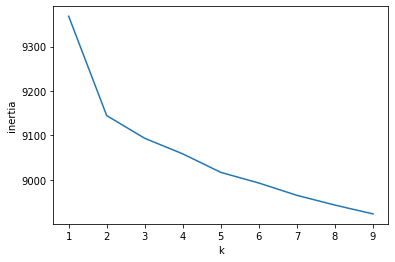

In [51]:
plt.plot([x for x in range(1, len(inertias) + 1)], inertias)
plt.xlabel('k')
plt.ylabel('inertia')
plt.show()

We can see that our k-means is pretty bad.. with inertia of around 9000.. But we did choose 1000 dimensions, so maybe data are pretty far part.

k = 5 seems like a better turning point than 2. Let's just pick k = 5.

In [52]:
km = KMeans(n_clusters = 5)
km.fit(tfidf_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

## 7.3 Now let's see the words that characterize each cluster.

In [53]:
km.cluster_centers_

array([[0.00514466, 0.00579936, 0.0061077 , ..., 0.00413277, 0.00286362,
        0.00889444],
       [0.00216298, 0.00504677, 0.0025899 , ..., 0.00336507, 0.00142543,
        0.00427739],
       [0.00353999, 0.00703205, 0.00432043, ..., 0.00177656, 0.00248713,
        0.01323159],
       [0.00424007, 0.0059498 , 0.00546244, ..., 0.00431304, 0.00330749,
        0.00862123],
       [0.00081867, 0.00688584, 0.00825519, ..., 0.00313211, 0.00121768,
        0.00687   ]])

Each of these numbers is a TF-IDF of a word, let's find the top 5 TF-IDF words within each cluster. 

In [55]:
# numpy's argsort function returns the array
# [index in original array of smallest element, index ... of second smallest element, ...]
np.argsort([3,1,2])

array([1, 2, 0])

In [69]:
print('top 5 words that characterize cluster 0:')
# reverse because we are finding the highest TF-IDF, not the lowest
indices_of_words = np.argsort(km.cluster_centers_[0])[::-1][:5]
for index in indices_of_words:
  print(tfidf.get_feature_names()[index])

top 5 words that characterize cluster 0:
br
book
read
stori
like


In [70]:
for i in range(5):
  print(f'top 5 words that characterize cluster {i}:')
  indices_of_words = np.argsort(km.cluster_centers_[i])[::-1][:5]
  for index in indices_of_words:
    print(tfidf.get_feature_names()[index])
  print()

top 5 words that characterize cluster 0:
br
book
read
stori
like

top 5 words that characterize cluster 1:
book
use
great
help
inform

top 5 words that characterize cluster 2:
stori
charact
novel
book
read

top 5 words that characterize cluster 3:
br
book
read
like
time

top 5 words that characterize cluster 4:
book
read
love
enjoy
great



In [72]:
for i in range(5):
  print(f'top 10 words that characterize cluster {i}:')
  indices_of_words = np.argsort(km.cluster_centers_[i])[::-1][:10]
  for index in indices_of_words:
    print(tfidf.get_feature_names()[index])
  print()

top 10 words that characterize cluster 0:
br
book
read
stori
like
love
good
time
make
author

top 10 words that characterize cluster 1:
book
use
great
help
inform
good
read
like
make
recommend

top 10 words that characterize cluster 2:
stori
charact
novel
book
read
love
like
br
good
life

top 10 words that characterize cluster 3:
br
book
read
like
time
work
author
make
mani
good

top 10 words that characterize cluster 4:
book
read
love
enjoy
great
like
realli
time
good
year



Great! We now have the words that characterize different kinds of reviews. We can see that reviews from cluster 0 is all stories, cluster 1 is about "inform", so reader might be looking for informations and guidance in books. Cluster 2 is about characters and novels - so reviwers in this category probably reads fictions. Cluster 3 is about time - time travels? cluster 4 is about love, enjoy and great, probably by people who just enjoys reading for the sake of it. We found out different kinds of people give different reviews on books! This is super interesting.

# 8. Further Conclusion.

1.   K-means is excruciatingly slow. I was just doing k-means with 10000 documents, each document is represented as a 1000- dimensional vector, and it tooke me 30 minutes to do 10 k-means. In the future clustering analysis need to think of a better method that is more computationally efficient.
2.   there are more insights when I see what each cluster correspond to in terms of what are the most important words that characterize that cluster in terms of TF-IDF score. 
  - Found out that some reviews like novels, some read because they just enjoy it, some would recommend books to others, some read books because they like the author.
  - these are great insights for Amazon because they can target each cluster of customers and recommend them different things. For example once we know a person loves novels, we can recommend good novels when they come out in the future.
3. There are many more ways to do topic modeling and document clustering, such as LDA. I am just scratching the surface here. But it is really fun! 

